In [319]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import resample_poly

In [332]:
folder_path =  r"C:\\Mouse3\\2023-07-26T15-50-38\\"

analog_file = os.path.join(folder_path,'AnalogInput.bin')
analog_data = np.fromfile(analog_file, dtype=np.float64).reshape(-1,2).transpose()
fs_analog = 1000 #samples per second
analog_time = np.arange(analog_data[0,:].shape[0])/fs_analog

digital_file = os.path.join(folder_path,'DigitalInput.bin')
digital_data = np.fromfile(digital_file, dtype=np.byte)
fs_digital = 3000 #samples per second
digital_time = np.arange(digital_data.shape[0])/fs_digital


In [333]:
# define fxns for aligning and extracting data

def extract_digital_channel(digital_data, channel_number):
     #channel_number goes from 0 to 7
     return digital_data & (1 << channel_number) > 0

def detect_edges(signal):
    edges =np.where(np.diff(signal) == 1)[0] +1# identify where in time frame signal
    return edges

def detect_rising_edges(signal):
    edges = np.where((np.diff(signal) > 0) & (signal[1:] == 1))[0] + 1 # identify where in time frame signal
    return edges

def align_signal_to_frames(signal_times, photodiode_time):
    aligned_times = []
    aligned_indices = []
    
    for signal_time in signal_times:
        next_frame_indices = np.where(photodiode_time > signal_time)[0]
        if len(next_frame_indices) > 0:
            aligned_index = next_frame_indices[0]
            aligned_time = photodiode_time[aligned_index]
        else:
            #can't align so ignore
            continue
        aligned_times.append(aligned_time)
        aligned_indices.append(aligned_index)
    
    return np.array(aligned_times), np.array(aligned_indices)

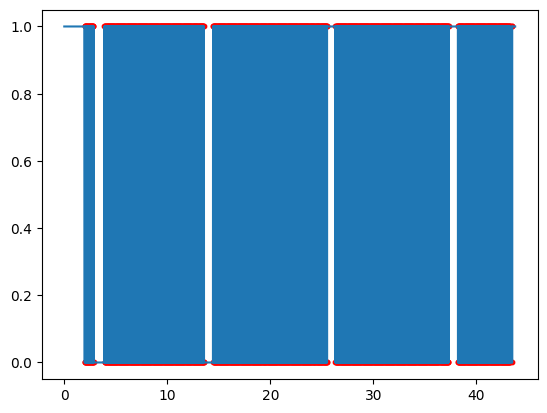

In [340]:
photodiode_signal = extract_digital_channel(digital_data, 2)
diode_time = detect_edges(photodiode_signal)/fs_digital

scanner_signal= extract_digital_channel(digital_data,0)
scanner_time =detect_rising_edges(scanner_signal)/fs_digital

valve_signal= extract_digital_channel(digital_data,4)
valve_time = detect_rising_edges(valve_signal)/fs_digital

piezo_signal = analog_data[0,:] # specify input
piezo_time = np.arange(piezo_signal.shape[0])/fs_analog

# align signals to frames
aligned_scanner_time, aligned_scanner_index = align_signal_to_frames(scanner_time, diode_time)
aligned_valve_time, aligned_valve_index = align_signal_to_frames(valve_time, diode_time)
aligned_piezo_time, aligned_piezo_index = align_signal_to_frames(piezo_time, diode_time)

valve = np.zeros_like(diode_time)
valve[aligned_valve_index] = 1

scanner = np.full(len(diode_time),np.nan)
for i, idx in enumerate(aligned_scanner_index):
    scanner[idx]=i+1


plt.figure()
plt.plot(digital_time, photodiode_signal)
plt.scatter(diode_time, photodiode_signal[detect_edges(photodiode_signal)], c='r', s=10)
plt.show()

[0.01       0.02533333 0.008      ... 0.159      0.02433333 0.009     ]
[ 30  76  24 ... 477  73  27]


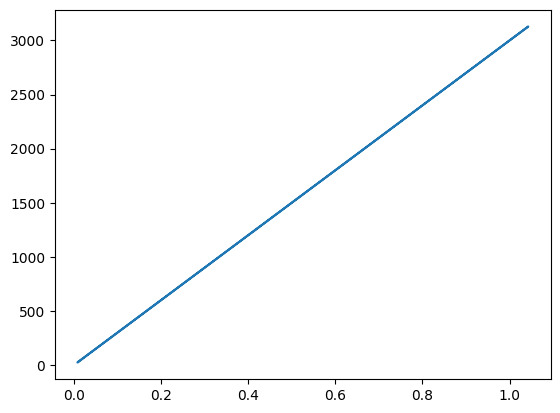

In [350]:
print(np.diff(diode_time))
print( np.diff(detect_edges(photodiode_signal)))
plt.figure()
plt.plot(np.diff(diode_time), np.diff(detect_edges(photodiode_signal)))
plt.show()

In [329]:
# read and align rotary encoder values
encoder_csv_data = pd.read_csv(os.path.join(folder_path,'RotaryEncoder.csv') )
encoder_csv_time=encoder_csv_data['RenderElapsedTime'].values
encoder_csv_values=encoder_csv_data['RotaryEncoder'].values
aligned_encoder_time, aligned_encoder_index = align_signal_to_frames(encoder_csv_time, diode_time)

# read and align vr pos values
vr_csv_data = pd.read_csv(os.path.join(folder_path,'VrPosition.csv') )
vr_csv_time= vr_csv_data['Time'].values
vr_csv_values=vr_csv_data['Position'].values
aligned_vr_time, aligned_vr_index = align_signal_to_frames(vr_csv_time, diode_time)

print(list(dict.fromkeys(aligned_vr_time).keys()))

# csv_file = r"C:\\Mouse3\\2023-07-26T14-21-53\\FrameEvents.csv"  # add position of encoder to aligned data array
# csv_data = pd.read_csv(csv_file)
# lick_index=np.where(csv_data['EventName'] == 'Lick')[0]
# lick_frame_indices = csv_data['Frame.Index'].values[lick_index]
# aligned_licks = np.zeros(len(frame_indices), dtype=int)
# aligned_licks[np.searchsorted(frame_indices, lick_frame_indices)] = 1
# teleport_index=np.where(csv_data['EventName'] == 'Teleport')[0]
# teleport_frame_indices = csv_data['Frame.Index'].values[teleport_index]
# aligned_teleport = np.zeros(len(frame_indices), dtype=int)
# aligned_teleport[np.searchsorted(frame_indices, teleport_frame_indices)] = 1
# reward_index=np.where(csv_data['EventName'] == 'Reward')[0]
# reward_frame_indices = csv_data['Frame.Index'].values[reward_index]
# aligned_reward = np.zeros(len(frame_indices), dtype=int)
# aligned_reward[np.searchsorted(frame_indices, reward_frame_indices)] = 1
# wallvis_index=np.where(csv_data['EventName'] == 'WallVisibility')[0]
# wallvs_indices = csv_data['Frame.Index'].values[wallvis_index]
# aligned_wallvis = np.zeros(len(frame_indices), dtype=int)
# aligned_wallvis[np.searchsorted(frame_indices, wallvs_indices)] = 1


1429


In [331]:
data = {
    'Diode Time': diode_time,
    'Diode Frame Index': detect_edges(photodiode_signal),
    'Scanner': scanner,
    'Valve': valve,
    # 'Encoder': aligned_encoder_values
    # 'Lick': aligned_licks,
    # 'Reward': aligned_reward,
    # 'Teleport': aligned_teleport,
    # 'WallVisibility': aligned_wallvis
}

behavior_data = pd.DataFrame(data)
print(behavior_data)

      Diode Time  Diode Frame Index  Scanner  Valve
0       1.977333               5932      NaN    0.0
1       1.987333               5962      NaN    0.0
2       2.012667               6038      NaN    0.0
3       2.020667               6062      NaN    0.0
4       2.045667               6137      NaN    0.0
...          ...                ...      ...    ...
2253   43.254000             129762      NaN    0.0
2254   43.278667             129836      NaN    0.0
2255   43.437667             130313      NaN    0.0
2256   43.462000             130386      NaN    0.0
2257   43.471000             130413      NaN    0.0

[2258 rows x 4 columns]


In [ ]:
plt.figure()
plt.plot(digital_time, photodiode_signal)
# plt.plot(digital_time,scanner_signal)
plt.scatter(diode_time, photodiode_signal[detect_edges(photodiode_signal)], c='r', s=10)
# plt.scatter(diode_time, scanner, c='r', s=10)
# plt.xlim(10, 10.1)
plt.show()

# plt.figure()
# plt.plot(digital_time, photodiode_signal)
# plt.plot(csv_frame_indices/fs_digital,aligned_encoder_values)
# plt.scatter(diode_time, photodiode_signal[detect_edges(photodiode_signal)], c='r', s=10)
# plt.scatter(scanner_edges / fs_digital, scanner_signal[scanner_edges], c='r', s=10)
# plt.xlim(22.4, 22.6)
# plt.show()

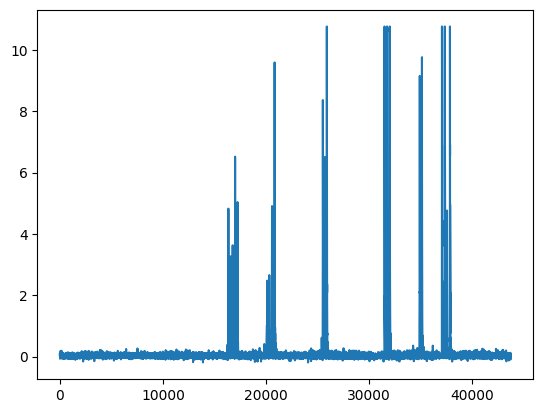

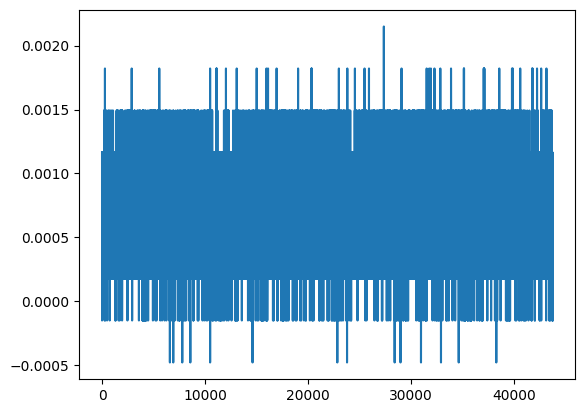

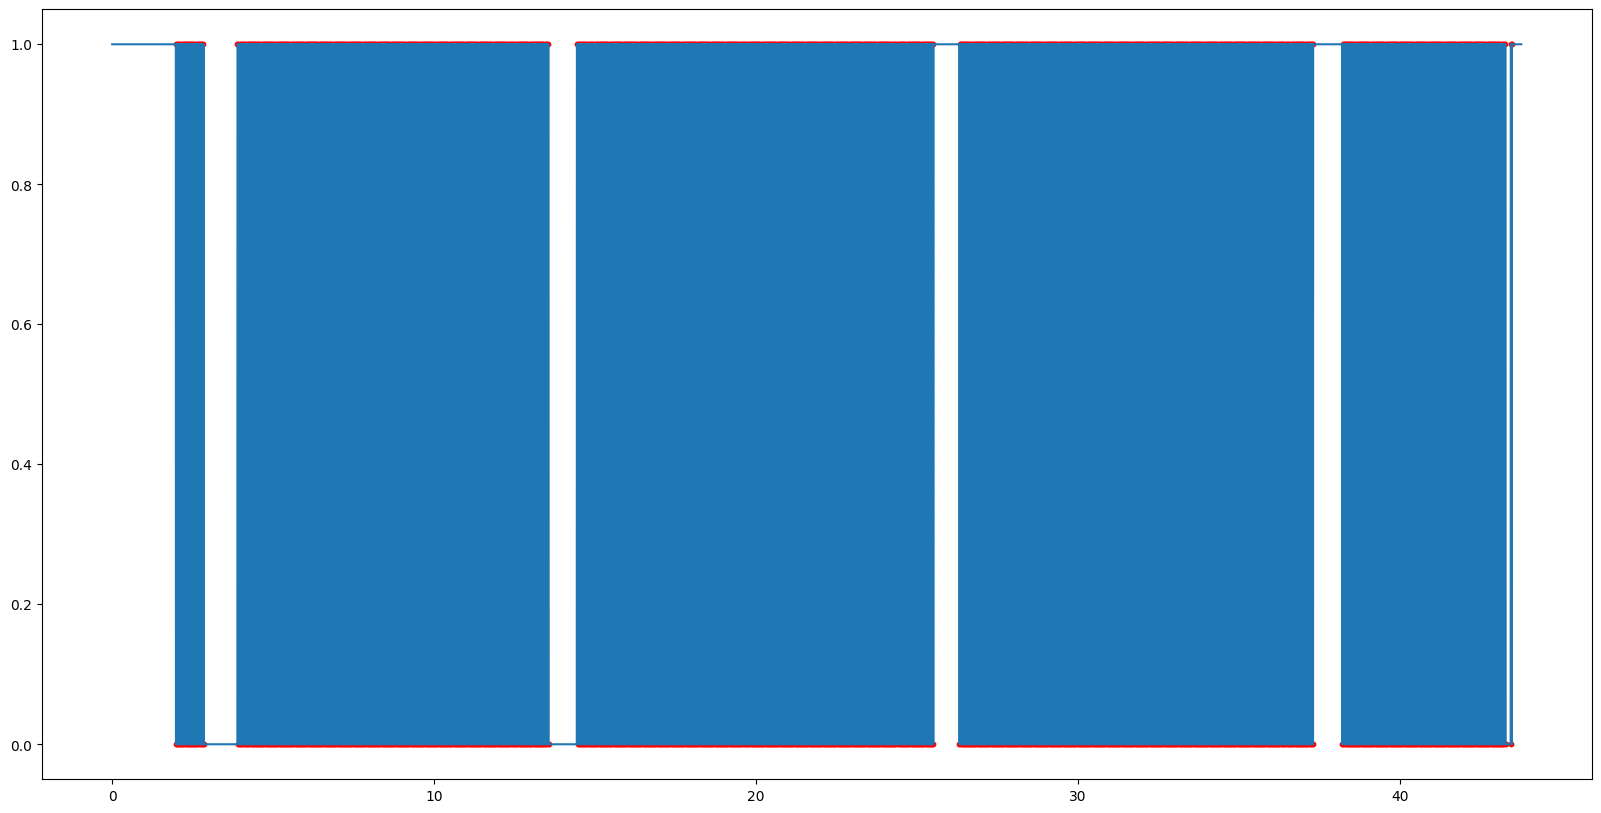

In [338]:
analog_data = np.fromfile(analog_file, dtype=np.float64).reshape(-1,2).transpose()
analog_piezo = analog_data[0,:] # specify input
analog_time = np.arange(analog_piezo.shape[0])/fs_analog

for i in range(analog_data.shape[0]): 
    plt.figure()
    plt.plot(analog_data[i,:])
    plt.show()

# photodiode_thresholded = (analog_photodiode > 0.3).astype(int) # set arbitrary threshold
# rising_edges = np.where(np.diff(photodiode_thresholded) == 1)[0] # identify where in time frame signal
# analog_time = np.arange(analog_photodiode.shape[0])/fs_analog #change time scale

# plot figure
plt.figure(figsize=(20,10))
# plt.plot(analog_time, analog_data[0,:])
plt.plot(digital_time,photodiode_signal)
plt.scatter(diode_time, photodiode_signal[detect_edges(photodiode_signal)], c='r', s=10)
# plt.xlim((95, 120))
plt.show()



In [ ]:
analog_data = np.fromfile(analog_file, dtype=np.float64).reshape(-1,2).transpose()
# for i in range(analog_data.shape[0]): 
#     plt.figure()
#     plt.plot(analog_data[i,:])
#     plt.show()

# analog_photodiode = analog_data[0,:] # specify input
# photodiode_thresholded = (analog_photodiode > 0.3).astype(int) # set arbitrary threshold
# rising_edges = np.where(np.diff(photodiode_thresholded) == 1)[0] # identify where in time frame signal
# analog_time = np.arange(analog_photodiode.shape[0])/fs_analog #change time scale
# plot figure
# plt.figure(figsize=(20,10))
# plt.plot(analog_time, analog_data[0,:])
# plt.plot(digital_time,)
# # plt.scatter(rising_edges / fs_analog, rising_edges*0 + 1, c='r', s=10)
# plt.xlim((0, 5))
# plt.show()
# print(rising_edges)



In [ ]:
analog_data = np.fromfile(analog_file, dtype=np.float64).reshape(-1,2).transpose()
print(len(analog_data[0,:]))
print(analog_data.shape)
# for i in range(analog_data.shape[0]): 
#     plt.figure()
#     plt.plot(analog_data[i,:])
#     plt.show()

analog_piezo = analog_data[0,:] # specify input
analog_time = np.arange(analog_piezo.shape[0])/fs_analog #change time scale
digital_time = np.arange(digital_data.shape[0])/fs_digital


# plot figure
plt.figure(figsize=(20,10))
plt.plot(analog_time, analog_piezo)
plt.plot(digital_time, photodiode_signal)
# plt.scatter(diode_rising_edges / fs_analog, diode_rising_edges*0 + 1, c='r', s=10)
# plt.xlim((0, 5))
plt.show()


In [ ]:
# digital_data = np.fromfile(digital_file, dtype=np.byte)
# digital_time = np.arange(digital_data.shape[0])/fs_digital

# def detect_rising_edges(signal):
#     edges = np.where((np.diff(signal) > 0) & (signal[1:] == 1))[0] + 1
#     return edges

# photodiode_signal = extract_digital_channel(digital_data, 2)
# diode_rising_edges = detect_rising_edges(photodiode_signal)
# # rising_edges = np.where(np.diff(extract_digital_channel(digital_data, 2)) == 1)[0] +1# identify where in time frame signal
# scanner_signal= np.logical_not(extract_digital_channel(digital_data,0))
# scanner_edges = detect_rising_edges(scanner_signal)
# frame_indices = np.arange(1, len(diode_rising_edges) + 1)
# scanner_frame_indices=np.arange(1, len(scanner_edges) + 1)
# aligned_scanner=np.searchsorted(scanner_frame_indices,frame_indices)

plt.figure()
plt.plot(digital_time, photodiode_signal)
plt.plot(digital_time,scanner_signal)
plt.scatter(diode_time, photodiode_signal[detect_edges(photodiode_signal)], c='b', s=10)
plt.scatter(scanner_time, scanner_signal[detect_rising_edges(scanner_signal)], c='r', s=10)
# plt.xlim(10, 10.1)
plt.show()


In [ ]:
## align and concatenate all digital and analog data using time stamps

aligned_data = np.zeros(len(digital_time), dtype=[('Timestamp', float), ('Analog_Data0', float), ('Analog_Data1', float), ('Analog_Data2', float),
                                                  ('Digital_Data0', int), ('Digital_Data1', int), ('Digital_Data2', int),('RotaryEncoder',float),('EventNames',str)])
aligned_data['Timestamp'] = digital_time
for i in range(len(analog_data)):
    aligned_data['Analog_Data'+ str(i)] = analog_data[i,:][np.searchsorted(analog_time,digital_time)]
    aligned_data['Digital_Data'+str(i)]= extract_digital_channel(digital_data, 2*i)  
# plt.figure()
# plt.plot(aligned_data['Timestamp'],aligned_data['Digital_Data0'], c = "b")
# plt.plot(aligned_data['Timestamp'],aligned_data['Analog_Data2'], c = "r")
# plt.show()
